In [ ]:
# 데이터를 불러오고 살펴보기 위한 pandas 라이브러리
import pandas as pd

#데이터 불러오기
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import os
ROOT = '/content/gdrive/MyDrive/2022_DSOB_WIDA/kr/data'
#DIR = 'data'

PATH = os.path.join(ROOT)
os.chdir(PATH)

Mounted at /content/gdrive


In [ ]:
from bs4 import BeautifulSoup
from datetime import datetime
import requests
import pandas as pd
import re
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''
< naver 뉴스 검색시 리스트 크롤링하는 프로그램 > _select사용
- 크롤링 해오는 것 : 링크,제목,신문사,날짜,내용요약본
- 날짜,내용요약본  -> 정제 작업 필요
- 리스트 -> 딕셔너리 -> df -> 엑셀로 저장
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''

#각 크롤링 결과 저장하기 위한 리스트 선언
title_text=[]
link_text=[]
source_text=[]
date_text=[]
contents_text=[]
result={}

#엑셀로 저장하기 위한 변수
#RESULT_PATH ='"/content/gdrive/MyDrive/2022_DSOB_WIDA"'  #결과 저장할 경로
now = datetime.now() #파일이름 현 시간으로 저장하기

#날짜 정제화 함수
def date_cleansing(test):
    try:
        #지난 뉴스
        #머니투데이  10면1단  2018.11.05.  네이버뉴스   보내기
        pattern = '\d+.(\d+).(\d+).'  #정규표현식

        r = re.compile(pattern)
        match = r.search(test).group(0)  # 2018.11.05.
        date_text.append(match)

    except AttributeError:
        #최근 뉴스
        #이데일리  1시간 전  네이버뉴스   보내기
        pattern = '\w* (\d\w*)'     #정규표현식

        r = re.compile(pattern)
        match = r.search(test).group(1)
        #print(match)
        date_text.append(match)


#내용 정제화 함수
def contents_cleansing(contents):
    first_cleansing_contents = re.sub('<dl>.*?</a> </div> </dd> <dd>', '',
                                      str(contents)).strip()  #앞에 필요없는 부분 제거
    second_cleansing_contents = re.sub('<ul class="relation_lst">.*?</dd>', '',
                                       first_cleansing_contents).strip()#뒤에 필요없는 부분 제거 (새끼 기사)
    third_cleansing_contents = re.sub('<.+?>', '', second_cleansing_contents).strip()
    contents_text.append(third_cleansing_contents)
    #print(contents_text)


def crawler(maxpage,query,sort,s_date,e_date):

    s_from = s_date.replace(".","")
    e_to = e_date.replace(".","")
    page = 1
    maxpage_t =(int(maxpage)-1)*10+1   # 11= 2페이지 21=3페이지 31=4페이지  ...81=9페이지 , 91=10페이지, 101=11페이지

    while page <= maxpage_t:
        url = "https://search.naver.com/search.naver?where=news&query=" + query + "&sort="+sort+"&ds=" + s_date + "&de=" + e_date + "&nso=so%3Ar%2Cp%3Afrom" + s_from + "to" + e_to + "%2Ca%3A&start=" + str(page)

        response = requests.get(url)
        html = response.text

        #뷰티풀소프의 인자값 지정
        soup = BeautifulSoup(html, 'html.parser')

        #<a>태그에서 제목과 링크주소 추출
        atags = soup.select('.news_tit')
        for atag in atags:
            title_text.append(atag.text)     #제목
            link_text.append(atag['href'])   #링크주소

        #신문사 추출
        source_lists = soup.select('.info_group > .press')
        for source_list in source_lists:
            source_text.append(source_list.text)    #신문사

        #날짜 추출
        date_lists = soup.select('.info_group > span.info')
        for date_list in date_lists:
            # 1면 3단 같은 위치 제거
            if date_list.text.find("면") == -1:
                date_text.append(date_list.text)

        #본문요약본
        contents_lists = soup.select('.news_dsc')
        for contents_list in contents_lists:
            contents_cleansing(contents_list) #본문요약 정제화


        #모든 리스트 딕셔너리형태로 저장
        result= {"date" : date_text , "title":title_text ,  "source" : source_text ,"contents": contents_text ,"link":link_text }
        print(page)

        df = pd.DataFrame(result)  #df로 변환
        page += 10

     #엑셀 파일 이름지정
# news_df.to_excel(excel_writer = '{}_{}.csv'.format(search,now.strftime('%Y%m%d_%H시%M분%S초')), sheet_name = 'Sheet1', index=False)

# #엑셀 파일 불러오기
# data = pd.read_csv('./2022_DSOB_11_COMP/GRID_ID_time_dataset_tour_weather_119_corona.xlsx')
    # 새로 만들 파일이름 지정
    outputFileName = '%s-%s-%s  %s시 %s분 %s초 merging.xlsx' % (now.year, now.month, now.day, now.hour, now.minute, now.second)
    df.to_excel(excel_writer = outputFileName,sheet_name='sheet1')
    #엑셀 파일 불러오기
    #data = pd.read_excel('./2022_DSOB_11_COMP/GRID_ID_time_dataset_tour_weather_119_corona.xlsx')



def main():
    info_main = input("="*50+"\n"+"입력 형식에 맞게 입력해주세요."+"\n"+" 시작하시려면 Enter를 눌러주세요."+"\n"+"="*50)

    maxpage = input("최대 크롤링할 페이지 수 입력하시오: ")
    query = input("검색어 입력: ")
    sort = input("뉴스 검색 방식 입력(관련도순=0  최신순=1  오래된순=2): ")    #관련도순=0  최신순=1  오래된순=2
    s_date = input("시작날짜 입력(2019.01.04):")  #2019.01.04
    e_date = input("끝날짜 입력(2019.01.05):")   #2019.01.05

    crawler(maxpage,query,sort,s_date,e_date)

main()

입력 형식에 맞게 입력해주세요.
 시작하시려면 Enter를 눌러주세요.
최대 크롤링할 페이지 수 입력하시오: 
검색어 입력: 
뉴스 검색 방식 입력(관련도순=0  최신순=1  오래된순=2): 
시작날짜 입력(2019.01.04):
끝날짜 입력(2019.01.05):


ValueError: ignored

In [ ]:
#엑셀 파일 불러오기
news= pd.read_excel('IHQ <매도>.xlsx')
news

,Unnamed: 0,date,title,source,contents,link
0,0,2019.11.11.,"[특징주] IHQ 1,905원, 11일 9시 40분 등락률 6.42%",글로벌경제,11월 11일 9시 40분 현재 IHQ(003560)이 전일 대비 6.42% 등락률...,http://www.getnews.co.kr/view.php?ud=201911110...
1,1,2019.11.11.,[특징주] IHQ ' 거래량 TOP10 ' 7위 종목 올라...,내외경제tv,11일 10시 기준 거래량 상위종목IHQ 종목은 11일 10시 기준 7위를 차지했다...,http://nbntv.co.kr/news/view/729483
2,2,2019.11.11.,"[엔터테인먼트 테마 오전 시황] 상승률 상위 종목, 큐브엔터 +15.84%·IHQ ...",공감신문,"큐브엔터, IHQ, 팬엔터테인먼트 등이 높은 상승률을 보이고 있다. 가장 많이 상승...",http://www.gokorea.kr/news/articleView.html?id...
3,3,2019.11.11.,"[방송과엔터테인먼트 업종 14시 현재 주식시황] 상승률 상위 종목, 큐브엔터 ...",CCTV뉴스,"Design, IHQ, 방송과엔터테인먼트, 방송과엔터테인먼트 순으로 높은 상승률을 ...",http://www.cctvnews.co.kr/news/articleView.htm...
4,4,2019.11.11.,"IHQ, +12.57% VI 발동",조선비즈,"IHQ(003560)가 VI가 발동했다. 전일 대비 12.57% 상승한 2,015원...",https://biz.chosun.com/site/data/html_dir/2019...
...,...,...,...,...,...,...
117,117,2020.04.09.,"위지윅스튜디오, +4.49% 상승폭 확대",조선비즈,"위지윅스튜디오 연관 테마IHQ(003560), 초록뱀(047820), 팬엔터테인먼트...",https://biz.chosun.com/site/data/html_dir/2020...
118,118,2020.04.09.,"위지윅스튜디오, +4.49% 상승폭 확대",조선비즈,"위지윅스튜디오 연관 테마IHQ(003560), 초록뱀(047820), 팬엔터테인먼트...",https://biz.chosun.com/site/data/html_dir/2020...
119,119,2020.04.09.,"위지윅스튜디오, +4.49% 상승폭 확대",조선비즈,"위지윅스튜디오 연관 테마IHQ(003560), 초록뱀(047820), 팬엔터테인먼트...",https://biz.chosun.com/site/data/html_dir/2020...
120,120,2020.04.09.,"위지윅스튜디오, +4.49% 상승폭 확대",조선비즈,"위지윅스튜디오 연관 테마IHQ(003560), 초록뱀(047820), 팬엔터테인먼트...",https://biz.chosun.com/site/data/html_dir/2020...


#데이터 전처리

In [ ]:
#폰트설치

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent 

In [ ]:
articles = news['contents'].tolist()
#print(len(articles))  # 30

articles = ' '.join(articles)
articles = articles[:10000]
articles

'11월 11일 9시 40분 현재 IHQ(003560)이 전일 대비 6.42% 등락률을 기록해 투자자들의 화제가 되고 있다. IHQ의 현재가는 1,905원으로 기록되고 있다. IHQ의 최고가는 2,325원으로 전일 종가 대비 29.89% 높은... 11일 10시 기준 거래량 상위종목IHQ 종목은 11일 10시 기준 7위를 차지했다. 11일 IHQ의 주가는 1900원 이고, 전일 대비 110원 상승하였다. IHQ의 11일 지정 상한가는 2325원, 지정 하한가는 1255원이다. IHQ의... 큐브엔터, IHQ, 팬엔터테인먼트 등이 높은 상승률을 보이고 있다. 가장 많이 상승하고 있는 큐브엔터의 현재가는 4,535이다. 전 거래일과 비교해 +15.84% 상승한 가격이다. 같은 기간 IHQ 종목은 +6.15%로 상승세를... Design, IHQ, 방송과엔터테인먼트, 방송과엔터테인먼트 순으로 높은 상승률을 보이고 있다.... IHQ의 현재가는 2,080원, 티비씨의 현재가는 1,475원, 제이웨이의 현재가는 1,105원으로 각각 전 거래일 보다... IHQ(003560)가\xa0VI가 발동했다.\xa0전일 대비 12.57% 상승한\xa02,015원에 거래되고 있다. IHQ 연관 테마IHQ(003560), 초록뱀(047820), 팬엔터테인먼트(068050), CJ ENM(035760), SM C&amp;C(048550), NEW(160550), 삼화네트웍스... [그래프]IHQ 차트 분석 ◆ 주체별 매매동향 - 전일 외국인 대량 순매도 지난 한달을 기준으로 보면 외국인이... [그래프]IHQ 외국인/기관 매매동향 한경로보뉴스 이 기사는 한국경제신문과 금융 AI 전문기업 씽크풀이... 현재 IHQ(003560)는 전일대비 17.88% 상승하여 2,110원 선에서 거래가 이루어지고 있다. 외국인, 기관 모두... 상장주식수 대비 거래량은 0.63%로 적정수준 최근 한달간 IHQ의 상장주식수 대비 거래량을 비교해보니... 이투데이=고종민 기자 | IHQ가 매각 재추진가능성

In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from konlpy.tag import Okt

tokenizer = Okt()
raw_pos_tagged = tokenizer.pos(articles, norm=True, stem=True) # POS Tagging
print(raw_pos_tagged)

[('11월', 'Number'), ('11일', 'Number'), ('9시', 'Number'), ('40분', 'Number'), ('현재', 'Noun'), ('IHQ', 'Alpha'), ('(', 'Punctuation'), ('003560', 'Number'), (')', 'Punctuation'), ('이', 'Noun'), ('전일', 'Noun'), ('대비', 'Noun'), ('6.42%', 'Number'), ('등락', 'Noun'), ('률', 'Noun'), ('을', 'Josa'), ('기록', 'Noun'), ('하다', 'Verb'), ('투자자', 'Noun'), ('들', 'Suffix'), ('의', 'Josa'), ('화제', 'Noun'), ('가', 'Josa'), ('되다', 'Verb'), ('있다', 'Adjective'), ('.', 'Punctuation'), ('IHQ', 'Alpha'), ('의', 'Noun'), ('현재', 'Noun'), ('가다', 'Verb'), ('1,905원', 'Number'), ('으로', 'Foreign'), ('기록', 'Noun'), ('되다', 'Verb'), ('있다', 'Adjective'), ('.', 'Punctuation'), ('IHQ', 'Alpha'), ('의', 'Noun'), ('최고', 'Noun'), ('가다', 'Verb'), ('2,325원', 'Number'), ('으로', 'Foreign'), ('전일', 'Noun'), ('종가', 'Noun'), ('대비', 'Noun'), ('29.89%', 'Number'), ('높다', 'Adjective'), ('...', 'Punctuation'), ('11일', 'Number'), ('10시', 'Number'), ('기준', 'Noun'), ('거래', 'Noun'), ('량', 'Noun'), ('상위', 'Noun'), ('종목', 'Noun'), ('IHQ', 'Alpha'), ('

In [ ]:
del_list = ['를', '이', '은', '는', '있다', '하다', '에']

word_cleaned = []
for word in raw_pos_tagged:
    if not word[1] in ["Josa", "Eomi", "Punctuation", "Foreign","Number","Determiner","Verb"]: # Foreign == ”, “ 와 같이 제외되어야할 항목들
        if (len(word[0]) != 1) & (word[0] not in del_list): # 한 글자로 이뤄진 단어들을 제외 & 원치 않는 단어들을 제외, 대신 "안, 못"같은 것까지 같이 지워져서 긍정,부정을 파악해야 되는경우는 제외하지 않는다.
            word_cleaned.append(word[0])

#print(word_cleaned)
len(word_cleaned)

1456

In [ ]:
from collections import Counter

result = Counter(word_cleaned)
word_dic = dict(result)
print(word_dic)


{'현재': 13, 'IHQ': 87, '전일': 22, '대비': 22, '등락': 1, '기록': 4, '투자자': 2, '화제': 1, '최고': 1, '종가': 2, '높다': 4, '기준': 19, '거래': 35, '상위': 17, '종목': 22, '차지': 1, '주가': 4, '상승': 45, '지정': 2, '상한': 1, '큐브': 18, '엔터테인먼트': 25, '승률': 4, '보이': 28, '가장': 1, '많이': 1, '일과': 1, '비교': 2, '가격': 4, '같다': 5, '기간': 4, '상승세': 26, 'Design': 6, '방송': 6, '티비': 8, '웨이': 4, '각각': 2, 'VI': 1, '발동': 1, '연관': 3, '테마': 7, '초록': 12, 'CJ': 3, 'ENM': 3, 'SM': 9, 'amp': 5, 'NEW': 5, '삼화': 4, '네트웍': 4, '그래프': 19, '차트': 18, '분석': 1, '주체': 1, '매매': 2, '동향': 2, '외국인': 8, '대량': 1, '매도': 1, '지난': 1, '기관': 14, '경로': 1, '뉴스': 3, '기사': 3, '한국': 4, '신문': 1, '금융': 2, 'AI': 6, '전문': 2, '기업': 3, '풀이': 2, '모두': 1, '상장': 5, '식수': 3, '거래량': 4, '적정': 1, '수준': 1, '최근': 5, '이투데이': 1, '고종': 1, '기자': 1, '매각': 4, '추진': 1, '가능성': 6, '강세': 1, '오전': 1, '오른': 5, '중이': 2, '최대': 5, '주인': 1, '라이브': 8, '회사': 1, '투자': 2, '은행': 1, 'IB': 1, '업계': 1, '국민': 1, '유선': 1, '채권': 1, '자회사': 7, '연예기획사': 2, '케이블': 1, '운영': 1, '보유': 15, '그동안': 1, '차례': 1, '시가총액': 

In [ ]:
sorted_word_dic = sorted(word_dic.items(), key=lambda x:x[1], reverse=True)
print(sorted_word_dic)

[('IHQ', 87), ('상승', 45), ('거래', 35), ('보이', 28), ('상승세', 26), ('엔터테인먼트', 25), ('시각', 23), ('전일', 22), ('대비', 22), ('종목', 22), ('거래소', 22), ('이외', 22), ('기준', 19), ('그래프', 19), ('큐브', 18), ('차트', 18), ('삼성', 18), ('상위', 17), ('일봉', 17), ('콘텐츠', 17), ('보유', 15), ('카드', 15), ('이월드', 15), ('기관', 14), ('현재', 13), ('초록', 12), ('알미늄', 11), ('스튜디오', 10), ('드래곤', 10), ('표시', 10), ('제이', 10), ('SM', 9), ('드라마', 9), ('남선', 9), ('단위', 9), ('티비', 8), ('외국인', 8), ('라이브', 8), ('보험', 8), ('제작', 8), ('콘텐트', 8), ('오로라', 8), ('웹툰', 8), ('창작가', 8), ('작가', 8), ('프로듀서', 8), ('관련', 8), ('핵심', 8), ('인력', 8), ('몸값', 8), ('테마', 7), ('자회사', 7), ('주요', 7), ('지사', 7), ('호에이', 7), ('경험', 7), ('능력', 7), ('업체', 7), ('Design', 6), ('방송', 6), ('AI', 6), ('가능성', 6), ('ideograph', 6), ('비씨', 6), ('월드', 6), ('제약', 6), ('iHQ', 6), ('사모펀드', 6), ('일부', 6), ('같다', 5), ('amp', 5), ('NEW', 5), ('상장', 5), ('최근', 5), ('오른', 5), ('최대', 5), ('미디어', 5), ('인수', 5), ('두산', 5), ('루스', 5), ('코스닥', 5), ('하락', 5), ('에프', 5), ('롯데', 5), (

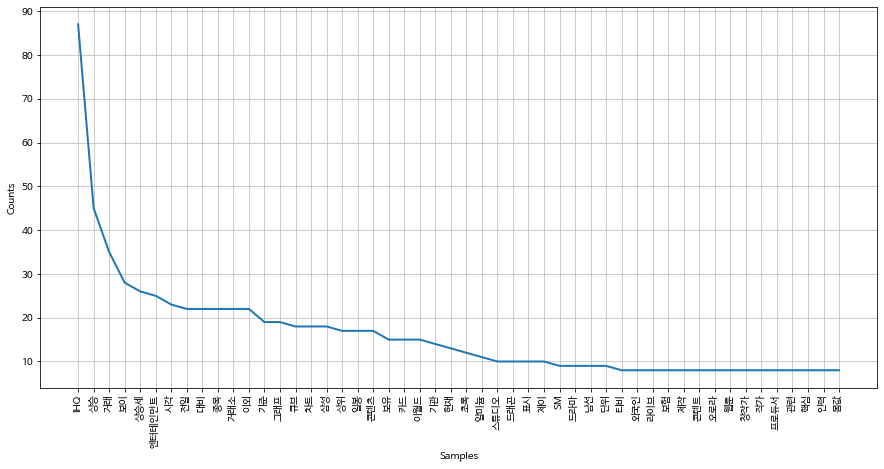

In [ ]:
import nltk
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc



word_counted = nltk.Text(word_cleaned)
plt.rc('font', family='NanumBarunGothic')
plt.figure(figsize=(15,7))
word_counted.plot(50)